# COMS6998 Final Report
Liushiya Chen $\quad$ Peimou Sun

In [1]:
PACKAGE_PATH = "F:\PSun-dev\Python\mlpp_project"
import os
import sys
sys.path.append(PACKAGE_PATH)

import collections
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import pyro
import torch
from pyro.optim import ClippedAdam

from ldavi.bbvi import LDABBVI
from ldavi.cavi import LDACAVI
from util import load_process

## 1. Problem statement and data description

### 1.1 Problem statement

The goal of this project is to model and understand grocery shoppers' purchase patterns on Instacart (online grocery platform) using Topic Modeling. The hypothesis is that, like text document, each order can be explained by a set of "topics". For example, a shopping cart with the following products: \{baby food, diapers, plant-based meat, soy milk\} might be explained by the "Baby" and "Veganism" topics. 

We conduct research on the differences between BBVI, the probabilistic method, and the traditional CAVI. 

### 1.2 Data description

In [2]:
order, data, vocab = load_process()
data[:2]

array([list(['spring water', 'calcium vitamin', 'bean yogurt', 'organic bananas', 'almondmilk pudding', 'provalone cheese', 'crushed organic', 'almond milk', 'smoked bacon', 'hashed browns', 'oil olive', 'organic raspberries', 'cultured butter', 'guacamole', 'black beans', 'sorbet pops', 'dish soap', 'slices cheese', 'grassmilk milk', 'kombucha gingerade', 'hothouse cucumbers', 'salt added', 'apple sauce', 'genoa salami', 'queso fresco', 'sausage patty', 'sliced pepperoni', 'organic garlic', 'allpurpose flour', 'laundry detergent', 'parsley bunch', 'organic buttermilk', 'yellow onion', 'chicken broth', 'string cheese', 'garbanzo beans', 'organic ketchup', 'organic zucchini', 'green chiles', 'salt added', 'organic lemonade', 'maize tortillas', 'corn starch', 'hand soap', 'plastic spoons', 'aluminum foil', 'plastic wrap', 'coconut milk']),
       list(['salad dressing', 'seedless grapes', 'organic bananas', 'chopped salad', 'wheat bread', 'greek yogurt', 'salad tomatoes', 'brown rice', '

In [3]:
vocab

array(['acorn squash', 'adult mouthwash', 'agave nectar', ...,
       'zucchini noodles', 'zucchini spirals', 'zucchini squash'],
      dtype='<U33')

In [4]:
# process the validation data
split_ = int(0.9 * len(data))
train_data = data[:split_]
valid_data = data[split_:]

## 2. LDA model

The orders are represented as random mixtures over latent topics, where each topic is characterized by a distribution over products.

$K$ = number of topics, $\quad$ $O$ = number of orders, 

$V$ = total number of unique products, $\quad$ $N_i$ = number of products in order $i$,

**Prior parameters:** $\alpha, \beta: \alpha_i>0, \beta_i\in[0,1]^V, \sum_j\beta_{i,j}=1$, where $i = 1\dots K$


**Data generation process:**

1. For each order $i$: $\theta_i\sim$ $Dir(\alpha$), where $\theta_i \in [0,1]^K, \sum_j\theta_{i,j}=1$.

2. For each product $j\in[1..N_i]$ in order $i$: 

$\quad$ 2a. pick topic $z_{i,j}\sim$ Categorical($\theta_i$) 

$\quad$ 2b. pick product $p_{i,j}\sim$ Categorical($\beta_{z_{i,j}}$)


**Joint distribution:**

$$\mathbb{P}(\mathbf{P}, \mathbf{Z},\boldsymbol{\theta};\alpha,\beta) = \prod\limits^O_{i=1} \Pr(\theta_i;\alpha)\prod\limits^{N_i}_{j=1} \Pr(z_{i,j}|\theta_j)\Pr(\mathbf{P}_{i,j}|\beta_{z_{i, j}})$$ 


## 3. Inference

The task in inference part is to find the posterior distribution for latent variables $(\theta, \mathbf{Z})$.

$$p(\boldsymbol{\theta}, \mathbf{Z}| \mathbf{P}, \alpha, \beta) = \prod\limits_{i = 1}^{O}\frac{p(\theta_i, \mathbf{z_i}, \mathbf{p_i}| \alpha, \beta)}{p(\mathbf{p_i} | \alpha, \beta)}$$

, where $\mathbf{z}_i$ denotes the topics vector and $\mathbf{p}_i$ denotes the products vector for the $i$th order. Based on the mean-field assumption, we will use BBVI and CAVI to approximate the posterior distribution and further compare the result of two inference algorithm. 

We calculate the ELBO and predictive probability here to show the optimization. We are using MC integral to calculate the predictive probability(with 10 particles). The general equation of predictive probability can be written as:

$$p(w) = \int_{z,\theta} p(w, z, \theta) dzd\theta = \int_{z,\theta} p(w| z, \theta) p(z, \theta)dzd\theta \approx \frac{1}{S}\sum_{i=1}^S p(w | z_i, \theta_i)$$

### 3.1 BBVI

In [ ]:
# Shiya
n_topics = 5
opt_params = {"lr": 0.005, "betas": (0.95, 0.999)}
n_steps = 100
n_particles = 1

bbiv_obj = LDABBVI(train_data, list(vocab), valid_data, ClippedAdam, n_topics, opt_params)
loss = bbiv_obj.run_svi(n_steps=n_steps, num_particles=n_particles)

0% (132507.2) (-122244.6) (-13403.3) | 

### 3.2 CAVI

In the CAVI algorithm, we approximate the posterior distribution in the order level with distribution(guide) $q(\theta, \mathbf{z} | \gamma, \phi)$, where $\gamma$ is a $(K, 1)$ vector and $\phi$ is a $(N_i, K)$ matrix. We further use EM algorithm to estimate the $\alpha$ and $\beta$. The iterative algorithm can be concluded as:

1) (E-step) Find the optimal $\gamma^{*}_i$ and $\phi^{*}_i$ in each document.

2) (M-step) Maximize the lower bound of likelihood $\mathcal{l}(\alpha, \beta) = \sum_{d=1}^{M} \log{p}(\mathbf{w}_d | \alpha, \beta)$ based on the parameters we got in the E-step.

The detailed derivation can be found in reference 1. 

In this example, the number of topic is 5 and $\alpha$ and $\beta$ are randomly initialized. We also use the last 20% data as validation set. Note that we only use 10 particles to estimate the predictive probability. The ELBO may not smaller than the log probability due to the error of MC integral. 

In [4]:
# model settings
num_topics = 5
corpora = list(vocab)

# initialize the parameters
alpha = torch.rand(size=(num_topics, )) * 10
beta = torch.rand(size=(len(alpha), len(vocab))) 
beta /= beta.sum(-1).view(-1, 1)

# instantialize the cavi_obj
cavi_obj = LDACAVI(alpha, beta, corpora, num_topics, num_particles=1)

In [7]:
cavi_obj.reset_graph()

# Parameter estimation
alpha, beta = cavi_obj.estimate_params(train_data, valid_data, 
                                       tol=2e-3, show_step=1, max_iter=10)
#Approximately 5 minutes for each step. Need more than 1 hour for training.

Step 1 | beta diff norm=0.1233 | alpha diff norm=6.0677 | ELBO=-59997.693 | Log_prob=-59083.706 | Validate_prob=-6622.085
Step 2 | beta diff norm=0.0178 | alpha diff norm=5.8572 | ELBO=-52703.128 | Log_prob=-51972.884 | Validate_prob=-6623.674


The ELBO increase monotonously in CAVI algorithm, but the predictive probability decrease first and then converge. The phenomenon is probabaly caused by estimation process of $\alpha$ and $\beta$. The estimation of $\alpha$ depends on $\gamma$, while the esimation of $\gamma$ depends on the updates of $\phi$. Since the estimation of $\beta$ only depends on $\phi$, the estimation of $\alpha$ accumulates the estimation error of phi and beta. The update order can be shown as follows:
 
**Document(Order) CAVI level**:

$\phi \xrightarrow{} \gamma$ 

**EM Algorithm**:

$\phi \xrightarrow{} \beta$ $\quad$ $\gamma \xrightarrow{} \alpha$

(1.0, 2.0)

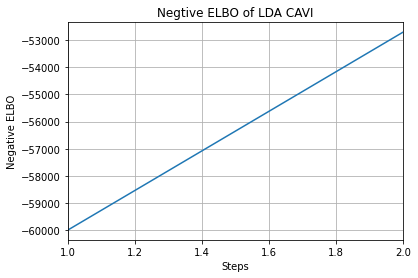

In [8]:
plt.plot(np.linspace(1, len(cavi_obj.trace_elbo), len(cavi_obj.trace_elbo)), cavi_obj.trace_elbo)
plt.title("Negtive ELBO of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Negative ELBO")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_elbo)))

(1.0, 2.0)

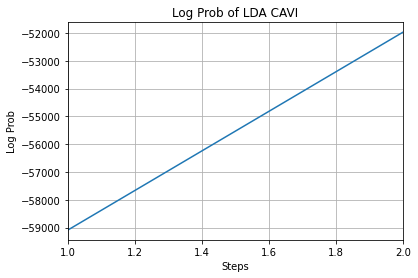

In [9]:
plt.plot(np.linspace(1, len(cavi_obj.trace_log_prob), len(cavi_obj.trace_log_prob)), cavi_obj.trace_log_prob)
plt.title("Log Prob of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Log Prob")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_log_prob)))

(1.0, 2.0)

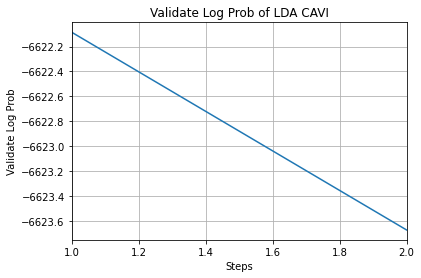

In [10]:
plt.plot(np.linspace(1, len(cavi_obj.trace_validate_prob), 
                     len(cavi_obj.trace_validate_prob)), cavi_obj.trace_validate_prob)
plt.title("Validate Log Prob of LDA CAVI")
plt.xlabel("Steps")
plt.ylabel("Validate Log Prob")
plt.grid()
plt.xlim((1, len(cavi_obj.trace_validate_prob)))

## 4. Criticism

### 4.1 Model criticism

In this section, we compare the influence of the number of topics in LDA model. The metric of the model is the predictive probability in the validation set. We only use BBVI in the criticism part.

### 4.2 Inference criticism

In [ ]:
# predictive log prob. Shiya MC inte

## 5. Improvement

## Reference